# CSE327 Homework 4
**Due date: 23:59 on Nov. 20, 2018 (Thuesday)**

## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 15-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 1,500 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 100 points. There is no bonus question for this homework. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
You will be using the same dataset in homework 3. The dataset contains 100 images from each category (i.e. 1500 training examples total and 1500 test cases total).  Download the dataset [here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing).

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data).

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

I am releasing a working setup on my computer for your reference: <br>
- OS: Windows 10 <br>
- Python: 3.5.2 <br>
- Pytorch (Stable + Windows + Conda + Python 3.5 + None): 0.4.1 <br>
OpenCV and Pillow is required.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================

class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print(class_names)

def img_norm(img):
    return 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            #print("filename ", filename)
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
    
#     # norm data to zero-centered
#     mean_img = np.mean(np.array(data), 0)
#     data = data - mean_img
#     data = [data[i] for i in xrange(data.shape[0])]
    
    # augment data
    if augment:
        aug_data = [np.flip(img, 1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

{0: 'Kitchen', 1: 'Office', 2: 'Mountain', 3: 'Street', 4: 'Forest', 5: 'TallBuilding', 6: 'Bedroom', 7: 'Suburb', 8: 'OpenCountry', 9: 'Industrial', 10: 'LivingRoom', 11: 'Store', 12: 'Highway', 13: 'InsideCity', 14: 'Coast'}


In [3]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_small = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))
#print("trainloader_small.shape >> ",trainloader_small[0].shape())

# load testing dataset
testloader_small = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))
#print("testloader_small.shape >> ",testloader_small.shape)

3000
50
Finish loading 60 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.


Highway


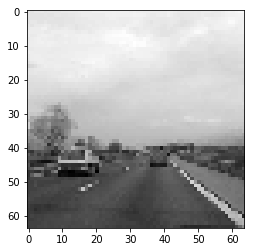

In [4]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 15-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 1,500 original training images as much (because it sees 3,000 training images now, although they're not as good as 3,000 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [18]:

# ==================================================
#         Network Architecture - my custom CNN 
# ===================================================


# =========================================================
#         2 convolutional layers 
#         with batch normalization, 
#         ReLU activation function 
#         maxpooling
#         and 1 fully connected layer (with dropout)
#         Named Parameters have been used with comments for better readability.
# ==========================================================

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.lyr1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, padding = 2), # default stride =1 
            nn.BatchNorm2d(num_features = 16),
            nn.ReLU(), # activation function
            nn.MaxPool2d(kernel_size = 2), # max pooling layer
            #nn.Dropout2d(p=0.45), # inserting  dropout before last convolution yields only ~54% accuracy
            ) 
        self.lyr2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 2),  # default stride =1 
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(), # activation function
            nn.MaxPool2d(kernel_size = 2) # max pooling layer 
            )
        self.fullyConnected = nn.Sequential(
            nn.Dropout2d(p=0.45), #### adding droput here gives 63% accuracy network regularization with dropout (p = probability)
            nn.Linear(in_features = 8192, out_features = 15) 
            ) 
        
    def forward(self, x):
        out = self.lyr1(x)
        out = self.lyr2(out)
        out = out.view(out.size(0), -1)
        out = self.fullyConnected(out)
        return out

In [19]:
train_start_time = time.time()

#create an instance 
customCNN = CustomCNN();


In [20]:

# ==========================================
#         Optimize/Train Network
# ==========================================


## Hyper-parameters
num_epochs = 80
learning_rate = 0.001 


# ==================================================
#         Training of Network Starts - my custom CNN 
# ===================================================


#optimizer = optim.RMSprop(customCNN.parameters(), lr=1e-4)
#loss_fn = nn.CrossEntropyLoss().type(dtype)
#optimizer = optim.Adam(params=customCNN.parameters(), lr=1e-6)

# =======================================================
#         Optimizer and loss function -  my custom CNN 
# =======================================================
loss_fn = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(customCNN.parameters(), lr=learning_rate);

#in train mode, batchnorm and dropouts active
customCNN.train()
losses = [];


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader_small):
        images = Variable(images.float())
        labels = Variable(labels.long())
        #print("images shape >> ", images.shape)
        
        # Forward + Backward + Optimize
        # Zero out all of the gradients for the variables which the optimizer will update.
        optimizer.zero_grad()
        
        # Forward pass: it predicts the scores for each class, for each image in the batch.
        outputs = customCNN(images)
        
        # Use the correct label values and the predicted label values to compute the loss.
        loss = loss_fn(outputs, labels)
        
        # Backwards pass: compute the gradient of the loss with respect to each parameter of the model.
        loss.backward()
        
        # Update the parameters of the model using the gradients computed by the backwards pass.
        optimizer.step()
        
        # append loss at every step
        losses.append(loss.data[0]);
        
        # for each 10th iteration print loss in a batch
        if (i+1) % 10 == 0: 
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(trainloader_small), loss.data[0])) #//batch_num

train_end_time = time.time() - train_start_time
print('------------------------------------------------------------')
print("time taken to TRAIN for my Custom CNN  in seconds {:.3f}".format(train_end_time))


# =========================================================
#            Evaluating/Testing Network - my custom CNN
# =========================================================

test_start_time = time.time()
#in test mode, batchnorm and dropouts in-active
customCNN.eval()
correctCount = 0
totalCount = 0

for images, labels in testloader_small:
    images = Variable(images.float())
    outputs = customCNN(images)
    _, pred_Y = torch.max(outputs.data, 1) # predict result
    totalCount += labels.size(0)
    correctCount += (pred_Y == labels).sum()
    
print('------------------------------------------------------------')
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correctCount / totalCount))

test_end_time = time.time() - test_start_time 
print("time taken to TEST for My Custom CNN in seconds {:.3f}".format(test_end_time))
print('------------------------------------------------------------')

/home/shayan_ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shayan_ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch : 1/80, Iter : 10/60,  Loss: 2.5627
Epoch : 1/80, Iter : 20/60,  Loss: 2.4170
Epoch : 1/80, Iter : 30/60,  Loss: 1.6993
Epoch : 1/80, Iter : 40/60,  Loss: 1.9603
Epoch : 1/80, Iter : 50/60,  Loss: 2.0126
Epoch : 1/80, Iter : 60/60,  Loss: 1.8196
Epoch : 2/80, Iter : 10/60,  Loss: 1.2633
Epoch : 2/80, Iter : 20/60,  Loss: 1.6619
Epoch : 2/80, Iter : 30/60,  Loss: 1.0536
Epoch : 2/80, Iter : 40/60,  Loss: 1.2463
Epoch : 2/80, Iter : 50/60,  Loss: 1.2748
Epoch : 2/80, Iter : 60/60,  Loss: 1.2624
Epoch : 3/80, Iter : 10/60,  Loss: 1.0245
Epoch : 3/80, Iter : 20/60,  Loss: 1.1385
Epoch : 3/80, Iter : 30/60,  Loss: 0.7264
Epoch : 3/80, Iter : 40/60,  Loss: 0.8835
Epoch : 3/80, Iter : 50/60,  Loss: 0.9854
Epoch : 3/80, Iter : 60/60,  Loss: 0.8559
Epoch : 4/80, Iter : 10/60,  Loss: 0.9017
Epoch : 4/80, Iter : 20/60,  Loss: 0.9188
Epoch : 4/80, Iter : 30/60,  Loss: 0.5677
Epoch : 4/80, Iter : 40/60,  Loss: 0.5971
Epoch : 4/80, Iter : 50/60,  Loss: 0.8452
Epoch : 4/80, Iter : 60/60,  Loss:

Epoch : 33/80, Iter : 10/60,  Loss: 0.0742
Epoch : 33/80, Iter : 20/60,  Loss: 0.0197
Epoch : 33/80, Iter : 30/60,  Loss: 0.0853
Epoch : 33/80, Iter : 40/60,  Loss: 0.0234
Epoch : 33/80, Iter : 50/60,  Loss: 0.0617
Epoch : 33/80, Iter : 60/60,  Loss: 0.0965
Epoch : 34/80, Iter : 10/60,  Loss: 0.0263
Epoch : 34/80, Iter : 20/60,  Loss: 0.1802
Epoch : 34/80, Iter : 30/60,  Loss: 0.0390
Epoch : 34/80, Iter : 40/60,  Loss: 0.0350
Epoch : 34/80, Iter : 50/60,  Loss: 0.0300
Epoch : 34/80, Iter : 60/60,  Loss: 0.0260
Epoch : 35/80, Iter : 10/60,  Loss: 0.0935
Epoch : 35/80, Iter : 20/60,  Loss: 0.0194
Epoch : 35/80, Iter : 30/60,  Loss: 0.0480
Epoch : 35/80, Iter : 40/60,  Loss: 0.0627
Epoch : 35/80, Iter : 50/60,  Loss: 0.0516
Epoch : 35/80, Iter : 60/60,  Loss: 0.0091
Epoch : 36/80, Iter : 10/60,  Loss: 0.0347
Epoch : 36/80, Iter : 20/60,  Loss: 0.0402
Epoch : 36/80, Iter : 30/60,  Loss: 0.0267
Epoch : 36/80, Iter : 40/60,  Loss: 0.0139
Epoch : 36/80, Iter : 50/60,  Loss: 0.0174
Epoch : 36/

Epoch : 64/80, Iter : 60/60,  Loss: 0.0045
Epoch : 65/80, Iter : 10/60,  Loss: 0.0135
Epoch : 65/80, Iter : 20/60,  Loss: 0.0224
Epoch : 65/80, Iter : 30/60,  Loss: 0.0739
Epoch : 65/80, Iter : 40/60,  Loss: 0.0338
Epoch : 65/80, Iter : 50/60,  Loss: 0.0070
Epoch : 65/80, Iter : 60/60,  Loss: 0.0178
Epoch : 66/80, Iter : 10/60,  Loss: 0.0121
Epoch : 66/80, Iter : 20/60,  Loss: 0.0854
Epoch : 66/80, Iter : 30/60,  Loss: 0.0040
Epoch : 66/80, Iter : 40/60,  Loss: 0.0368
Epoch : 66/80, Iter : 50/60,  Loss: 0.0078
Epoch : 66/80, Iter : 60/60,  Loss: 0.0104
Epoch : 67/80, Iter : 10/60,  Loss: 0.0015
Epoch : 67/80, Iter : 20/60,  Loss: 0.0490
Epoch : 67/80, Iter : 30/60,  Loss: 0.0200
Epoch : 67/80, Iter : 40/60,  Loss: 0.0024
Epoch : 67/80, Iter : 50/60,  Loss: 0.0094
Epoch : 67/80, Iter : 60/60,  Loss: 0.0045
Epoch : 68/80, Iter : 10/60,  Loss: 0.0046
Epoch : 68/80, Iter : 20/60,  Loss: 0.0183
Epoch : 68/80, Iter : 30/60,  Loss: 0.0403
Epoch : 68/80, Iter : 40/60,  Loss: 0.0062
Epoch : 68/

## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 15 scene database) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>
**DO NOT** turn in the downloaded AlexNet, I will download it myself to test your network.

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [8]:

# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, is_color=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

1500
50
Finish loading 30 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.


In [9]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
import torchvision.models as models
from torch.optim import lr_scheduler
import time
import copy

train_start_time = time.time()
#Hyperparameters
num_epochs_ft = 60;
learning_rate_ft = 0.001;

# =================================================================
#        Setup Alexnet(pretrained=True)
# ======================================================================

# as per Piazza notes, we should be using a pretrained model, weights should be initialized from pretrained alexnet.
model_ft = models.alexnet(pretrained=True) #pretrained=True

for param in model_ft.parameters():
    param.requires_grad = False # pretrained

    
# =======================================================================================================================
#      Changed only the last layer of classification to alter the number of image types/ number of classes which is 15. 
# ========================================================================================================================

num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6].out_features = 15  ## number of image classes is 15 for us - that was to be changed.

# create two list for feature and classifier blocks
## debug - list features and classifier layer details
ft_list = list(model_ft.features)
cl_list = list(model_ft.classifier)

print("\n new features ", ft_list)
print("\n new classifer ", cl_list)

## make sure there is no freezing anywhere
for param in model_ft.classifier[6].parameters():
    param.requires_grad = True


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# loss function
lossfn_ft = nn.CrossEntropyLoss()

# =================================================================
#         Optimizer -  alexnet(pretrained=True)
# ======================================================================

# All parameters to be optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate_ft, momentum=0.9)
#optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=learning_rate_ft);




 new features  [Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), ReLU(inplace), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), ReLU(inplace), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)]

 new classifer  [Dropout(p=0.5), Linear(in_features=9216, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace), Linear(in_features=4096, out_features=15, bias=True)]


In [16]:
# =================================================================
#         Training starts -  alexnet(pretrained=True)
# ======================================================================


model_ft.train()
losses_ft = [];


for epoch in range(num_epochs_ft):
    for i, (images, labels) in enumerate(trainloader_large):
        images = Variable(images.float())
        labels = Variable(labels)
        #print("images shape >> ", images.shape)
        
        # Forward + Backward + Optimize
        # Zero out all of the gradients for the variables which the optimizer will update.
        
        optimizer_ft.zero_grad()
        
        # Forward pass: it predicts the scores for each class, for each image in the batch.
        outputs = model_ft(images)
        #print("outputs shape >> ", outputs.shape)
        #print("labels shape >> ", labels.shape)
        
        # Use the correct label values and the predicted label values to compute the loss.
        loss = lossfn_ft(outputs, labels)
        
        # Backwards pass: compute the gradient of the loss with respect to each parameter of the model.
        loss.backward()
        
        # Update the parameters of the model using the gradients computed by the backwards pass.
        optimizer_ft.step()
        
        # append loss at every step
        losses_ft.append(loss.data[0]);
        
        if (i+1) % 10 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs_ft, i+1, len(trainloader_large), loss.data[0])) #//batch_num

train_end_time = time.time() - train_start_time
print('----------------------------------------------------------------')
print("time taken to TRAIN for non-pretrained AlexNet in seconds {:.3f}".format(train_end_time))


/home/shayan_ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shayan_ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch : 1/60, Iter : 10/30,  Loss: 0.0558
Epoch : 1/60, Iter : 20/30,  Loss: 0.0904
Epoch : 1/60, Iter : 30/30,  Loss: 0.1908
Epoch : 2/60, Iter : 10/30,  Loss: 0.0541
Epoch : 2/60, Iter : 20/30,  Loss: 0.0588
Epoch : 2/60, Iter : 30/30,  Loss: 0.1190
Epoch : 3/60, Iter : 10/30,  Loss: 0.1082
Epoch : 3/60, Iter : 20/30,  Loss: 0.1069
Epoch : 3/60, Iter : 30/30,  Loss: 0.1251
Epoch : 4/60, Iter : 10/30,  Loss: 0.0502
Epoch : 4/60, Iter : 20/30,  Loss: 0.1078
Epoch : 4/60, Iter : 30/30,  Loss: 0.1038
Epoch : 5/60, Iter : 10/30,  Loss: 0.0260
Epoch : 5/60, Iter : 20/30,  Loss: 0.1008
Epoch : 5/60, Iter : 30/30,  Loss: 0.0823
Epoch : 6/60, Iter : 10/30,  Loss: 0.1164
Epoch : 6/60, Iter : 20/30,  Loss: 0.0775
Epoch : 6/60, Iter : 30/30,  Loss: 0.1472
Epoch : 7/60, Iter : 10/30,  Loss: 0.0642
Epoch : 7/60, Iter : 20/30,  Loss: 0.1477
Epoch : 7/60, Iter : 30/30,  Loss: 0.1392
Epoch : 8/60, Iter : 10/30,  Loss: 0.0846
Epoch : 8/60, Iter : 20/30,  Loss: 0.0990
Epoch : 8/60, Iter : 30/30,  Loss:

In [17]:
# ================================================
#            Evaluating/Testing Network - Alexnet
# ================================================
test_start_time = time.time()
model_ft.eval()
correctCount_ft = 0
totalCount_ft = 0

for images, labels in testloader_large:
    images = Variable(images.float())
    outputs = model_ft(images)
    _, pred_Y = torch.max(outputs.data, 1)
    totalCount_ft += labels.size(0)
    correctCount_ft += (pred_Y == labels).sum()

print('------------------------------------------------------------')
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correctCount_ft / totalCount_ft))
test_end_time = time.time() - test_start_time 
print("time taken to TEST for non-pretrained AlexNet in seconds {:.3f}".format(test_end_time))

------------------------------------------------------------
Test Accuracy of the model on the 10000 test images: 85.0000 %
time taken to TEST for non-pretrained AlexNet in seconds 42.857


In [12]:
######################### Q2 Part2: activations of the pre-trained network as features to train one-vs-all SVMs 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
import torchvision.models as models
from torch.optim import lr_scheduler
import time
import copy


# ==============================================================================================
#           Training Network - Get activations from previously trained Alexnet as inputs to SVM
# ==============================================================================================
train_start_time = time.time()
model_svm = models.alexnet(pretrained=True) #pretrained=True

for param in model_svm.parameters():
    param.requires_grad = False # pretrained

model_svm.train()
num_epochs_svm=1


losses_ft = [];
train_ftr = [] 
train_lbls = []

svms = LinearSVC(C=0.091, tol=5e-3, loss='hinge', penalty='l2', random_state=42)

for epoch in range(num_epochs_svm):
    for i, (images, labels) in enumerate(trainloader_large):
        images = Variable(images.float())
        labels = Variable(labels)
        #print("images shape >> ", images.shape)
        #print("labels shape >> ", len(labels))
        
        # Forward pass: it predicts the scores for each class, for each image in the batch.
        outputs = model_svm(images)
        #print("outputs shape >> ", outputs.shape)

        #collect the features and labels from all batches and store them in a list of tensors
        N, C = outputs.size() 
        flattened1d =  outputs.view(N, -1) 
        #print("flattened1d " ,flattened1d)
        
        
        # add all the activations from last layer - using GCP so no Out of Memory issues.
        train_ftr.extend(flattened1d)
        train_lbls.extend(labels)
        
# convert the features and labels tensor list to a numpy array
ftrs = [t.numpy() for t in train_ftr]
lbls = [t.numpy() for t in train_lbls]

print("len(ftrs) >> ", len(ftrs))
print("len(lbls) >> ", len(lbls))

# train the svm - fit the model
svms.fit(np.asarray(ftrs),np.asarray(lbls))

train_end_time = time.time() - train_start_time
print('------------------------------------------------------------')
print("time taken to TRAIN for SVM in seconds {:.3f}".format(train_end_time))



len(ftrs) >>  1500
len(lbls) >>  1500
------------------------------------------------------------
time taken to TRAIN for SVM in seconds 49.922


In [13]:
test_start_time = time.time()
model_svm.eval()
correctCount_svm = 0
totalCount_svm = 0
for images, labels in testloader_large:
    images = Variable(images.float())
    outputs = model_svm(images)
    N, C = outputs.size() # read in N, C, H, W
    flattened1d =  outputs.view(N, -1) 
    pred_Y = svms.predict(flattened1d) # make predictions
    #_, predicted = torch.max(outputs.data, 1)
    totalCount_svm += labels.size(0)
    correctCount_svm += (pred_Y == labels).sum()
print('------------------------------------------------------------')
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correctCount_svm / totalCount_svm))

test_end_time = time.time() - test_start_time
print("time taken to TEST for CNN-SVM in seconds {:.3f}".format(test_end_time))


------------------------------------------------------------
Test Accuracy of the model on the 10000 test images: 81.0000 %
time taken to TEST for CNN-SVM in seconds 43.138


#  ----------------------------- MY REPORT  ---------------------------------------

##  ------------------------- My Execution Environment Details ---------------------

### Please note I have executed this homework on Google Cloud Platform (GCP) - CPU version :
Machine type
n1-standard-16 (16 vCPUs, 60 GB memory), Ubuntu 18.04 LTS
Python                    3.7.0
conda                     4.5.11
torchvision-cpu           0.2.1

As a result, the execution time gathered should be much faster than regular laptops.

Also due this configuration, I was able to use all 1000 activations from FC layer of Alexnet and feed it as an input to my SVM model successfully. I did not need to subsample it (i.e. take only 200 activations out of 1000 for my SVM training).

##  ------------------------- Accuracy and Timings for Q1(custom CNN) as logged above -----------

#### Hyperparameters
num_epochs = 80 

learning_rate = 0.001 

loss_fn = nn.CrossEntropyLoss();

optimizer = torch.optim.Adam(customCNN.parameters(), lr=learning_rate);


#### Training and Testing Time
time taken to TRAIN for my Custom CNN  in seconds 890.467

time taken to TEST for My Custom CNN in seconds 1.888

#### Test Accuracy
Test Accuracy of the model on the 10000 test images: 60.0000 %




##  ------------------------- Accuracy and Timings for Q2a(ALEXNET) as logged above -----------

#### Hyperparameters
num_epochs_ft = 60;

learning_rate_ft = 0.001;

lossfn_ft = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate_ft, momentum=0.9)


#### Training and Testing Time
time taken to TRAIN for non-pretrained(only last layer training reqd) AlexNet in seconds 3005.449

time taken to TEST for non-pretrained(only last layer training reqd) AlexNet in seconds 42.857

#### Test Accuracy
Test Accuracy of the model on the 10000 test images: 85.0000 %


### architecture change details
As already elaborated in the cells above, only the last layer of Alexnet has been modified to include 15 image classes as per our HW problem statement. All other layers and pre-trained weights were kept intact. This gave ~85% accuracy.

self.features = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            
        )
        self.classifier = nn.Sequential(
        
            nn.Dropout(),
            
            nn.Linear(256 * 6 * 6, 4096),
            
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            
            nn.Linear(4096, 4096),
            
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),  # only CHANGE: here num_classes was set to 15 in the code 
            
        )


##  ------------------------- Accuracy and Timings for Q2b(CNN-SVM) as logged above -----------

#### Hyperparameters
svms = LinearSVC(C=0.091, tol=5e-3, loss='hinge', penalty='l2', random_state=42)

num_epochs_svm=1

#### Training and Testing Time
time taken to TRAIN for SVM in seconds 49.922

time taken to TEST for CNN-SVM in seconds 43.138

#### Test Accuracy
Test Accuracy of the model on the 10000 test images: 81.0000 %


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>

<!--Write your report here in markdown or html-->
